In [39]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.2.2+cu121
True


In [40]:
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.io import read_image

torch.device("cuda")

device(type='cuda')

In [41]:
from torchvision import transforms
h,w = 64,64
data_transform = transforms.Compose([
    transforms.Resize(size=(h,w)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

12


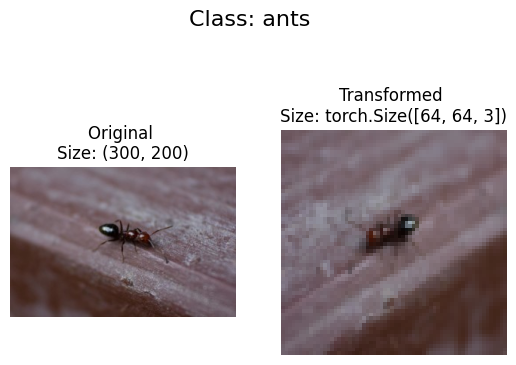

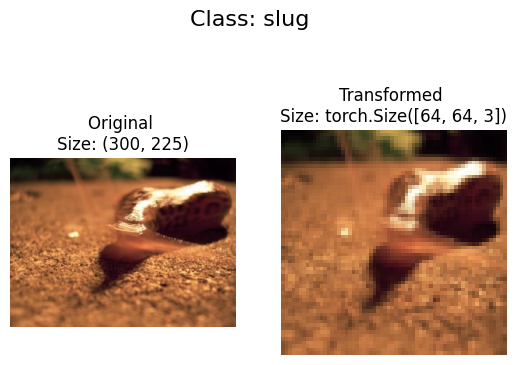

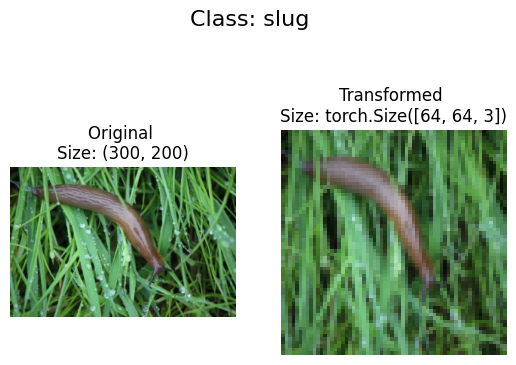

In [42]:
import random
from PIL import Image
from pathlib import Path


random.seed(42)

data_path = Path("../Data/Pest_Prediction_Pro/")
image_path = data_path / "Pest Prediction"
train_dir = image_path / "train"
test_dir = image_path / "test"
image_path_list = list(image_path.glob("*/*/*.jpg"))
num_subfolders = len([f for f in train_dir.iterdir() if f.is_dir()])

print(num_subfolders)
def plot_transformed_images(image_paths, transform, n=5, seed=11):
    seed = random.randint(1,100)
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [43]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

In [44]:
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True, num_workers=10,pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=True, num_workers=10,pin_memory=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 64, 64])
Shape of y: torch.Size([64]) torch.int64


In [45]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from matplotlib.animation import FuncAnimation
import time
import torch.optim as optim

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5, num_classes=12):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #model = torch.compile(model)  # Compile the model for faster training
    model.to(device)
    model.train()
    
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    epoch_times = []

    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        all_labels = []
        all_preds = []
        all_probs = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                all_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)

        end_time = time.time()
        epoch_times.append(end_time - start_time)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%, Time: {end_time - start_time:.2f}s")
        
        
        model.train()

    # Average time per epoch
    avg_epoch_time = np.mean(epoch_times)
    print(f"Average time per epoch: {avg_epoch_time:.2f} seconds")
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, num_epochs + 1), y=train_losses, marker='o', label='Train Loss')
    sns.lineplot(x=range(1, num_epochs + 1), y=test_losses, marker='o', label='Test Loss')
    plt.title('Training and Test Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"../Results/Loss_{model.__class__.__name__}.png")
    plt.show()
    
    # Plot training and test accuracy over epochs
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, num_epochs + 1), y=train_accuracies, marker='o', label='Train Accuracy')
    sns.lineplot(x=range(1, num_epochs + 1), y=test_accuracies, marker='o', label='Test Accuracy')
    plt.title('Training and Test Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.savefig(f"../Results/Accu_{model.__class__.__name__}.png")
    plt.show()
    

    # Confusion matrix plot
    conf_mat = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Reds', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f"../Results/ConfusionMatrix_{model.__class__.__name__}.png")
    plt.show()
    
    # ROC curve and AUC for each class
    all_labels = label_binarize(all_labels, classes=[i for i in range(num_classes)])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], np.array(all_probs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 10))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Each Class')
    plt.legend(loc="center right", bbox_to_anchor=(1, 0.5))
    plt.savefig(f"../Results/ROC_AUC_{model.__class__.__name__}.png")
    plt.show()
    
    # Radar chart for accuracy of each class
    class_accuracies = [accuracy_score(np.array(all_labels)[:, i], np.array(all_preds) == i) for i in range(num_classes)]
    categories = [f'Class {i}' for i in range(num_classes)]
    
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    class_accuracies += class_accuracies[:1]
    
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    ax.fill(angles, class_accuracies, color='blue', alpha=0.25)
    ax.plot(angles, class_accuracies, color='blue', linewidth=2)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_title('Class-wise Accuracy')
    plt.savefig(f"../Results/Radar{model.__class__.__name__}.png")
    plt.show()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
num_epochs = 20
learn_rate = 0.001

In [46]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(4608, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

class IntermediateCNN(nn.Module):
    def __init__(self, num_classes):
        super(IntermediateCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

class AdvancedCNN(nn.Module):
    def __init__(self, num_classes):
        super(AdvancedCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.global_avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

Epoch 1/20, Train Loss: 3.4876, Test Loss: 2.2284, Train Acc: 20.89%, Test Acc: 29.21%, Time: 93.22s
Epoch 2/20, Train Loss: 2.0010, Test Loss: 2.0108, Train Acc: 34.38%, Test Acc: 35.40%, Time: 94.21s
Epoch 3/20, Train Loss: 1.8579, Test Loss: 2.0334, Train Acc: 39.11%, Test Acc: 36.40%, Time: 103.12s
Epoch 4/20, Train Loss: 1.7253, Test Loss: 1.7999, Train Acc: 42.43%, Test Acc: 42.86%, Time: 94.39s
Epoch 5/20, Train Loss: 1.5897, Test Loss: 1.7992, Train Acc: 47.80%, Test Acc: 41.95%, Time: 95.04s
Epoch 6/20, Train Loss: 1.5213, Test Loss: 1.8503, Train Acc: 49.08%, Test Acc: 40.86%, Time: 97.71s
Epoch 7/20, Train Loss: 1.4412, Test Loss: 1.7334, Train Acc: 52.40%, Test Acc: 43.40%, Time: 99.04s
Epoch 8/20, Train Loss: 1.3427, Test Loss: 1.7502, Train Acc: 55.27%, Test Acc: 46.31%, Time: 99.50s
Epoch 9/20, Train Loss: 1.2306, Test Loss: 1.7894, Train Acc: 59.39%, Test Acc: 43.68%, Time: 97.17s
Epoch 10/20, Train Loss: 1.1738, Test Loss: 2.1083, Train Acc: 61.37%, Test Acc: 41.13%, T

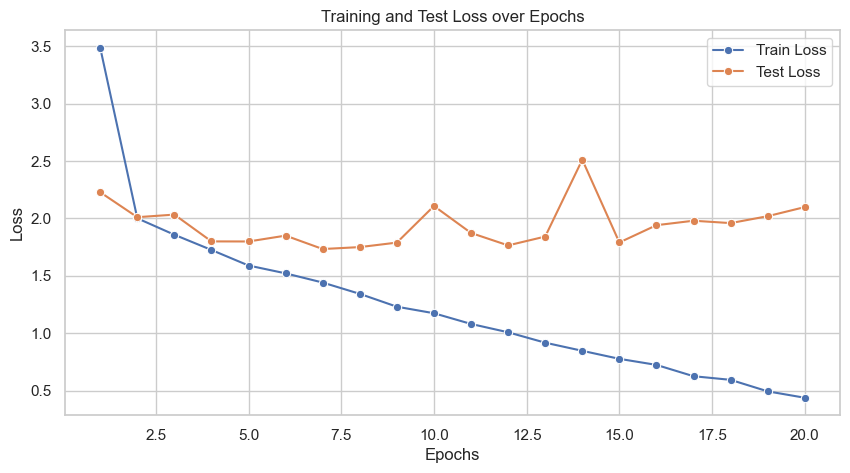

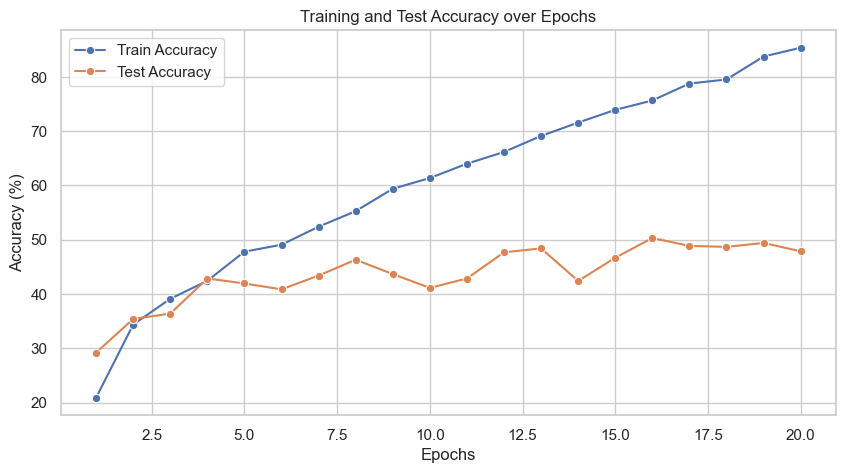

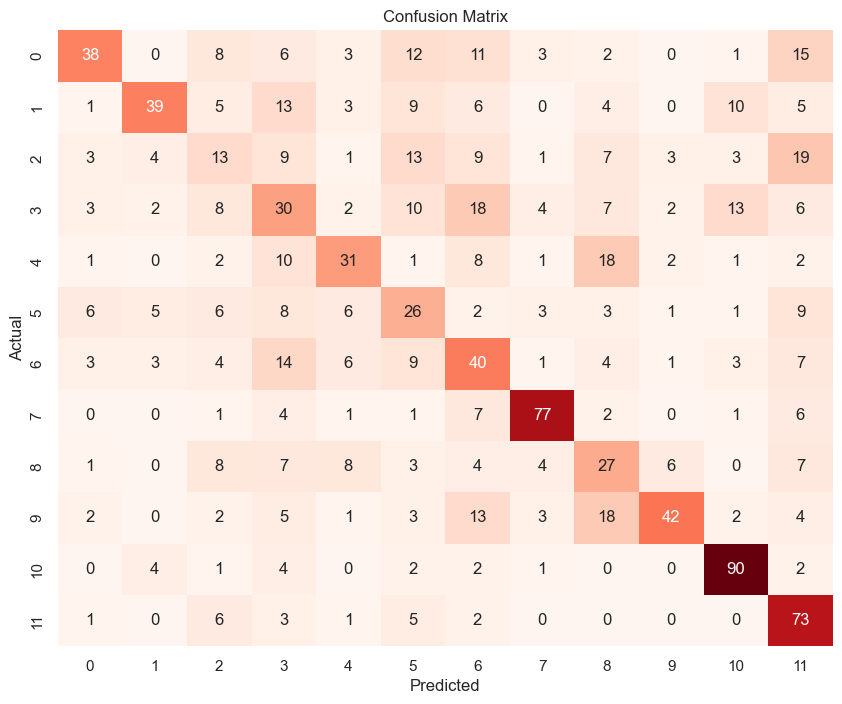

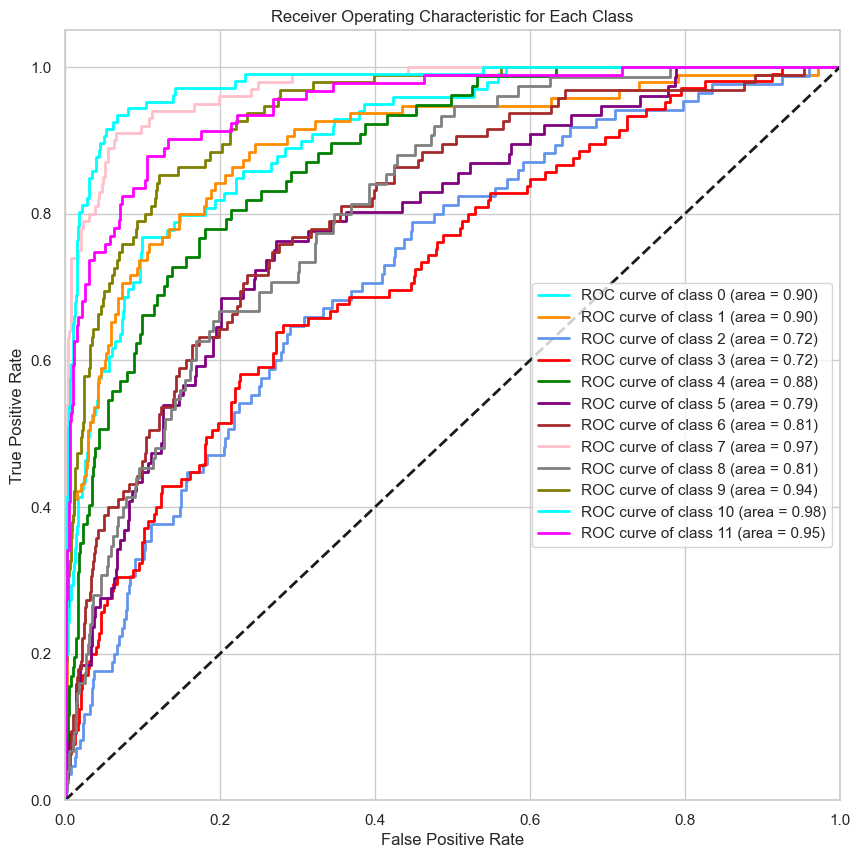

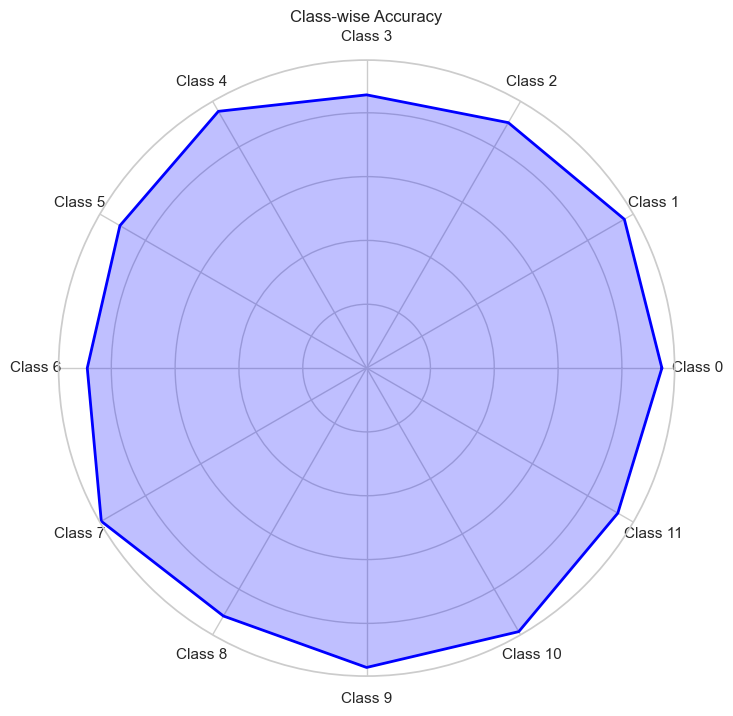

In [47]:
model1 = SimpleCNN(num_classes=12)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learn_rate)

torch.cuda.empty_cache()
train_model(model1,train_dataloader,test_dataloader,criterion, optimizer, num_epochs=num_epochs)
torch.cuda.empty_cache()

Epoch 1/20, Train Loss: 2.2578, Test Loss: 2.0206, Train Acc: 24.14%, Test Acc: 31.48%, Time: 100.71s
Epoch 2/20, Train Loss: 1.9766, Test Loss: 2.1983, Train Acc: 34.11%, Test Acc: 32.48%, Time: 102.08s
Epoch 3/20, Train Loss: 1.8470, Test Loss: 2.0353, Train Acc: 38.36%, Test Acc: 36.12%, Time: 98.64s
Epoch 4/20, Train Loss: 1.7427, Test Loss: 1.8601, Train Acc: 41.43%, Test Acc: 39.31%, Time: 99.31s
Epoch 5/20, Train Loss: 1.6584, Test Loss: 1.6496, Train Acc: 45.16%, Test Acc: 46.31%, Time: 98.97s
Epoch 6/20, Train Loss: 1.5599, Test Loss: 1.7091, Train Acc: 46.80%, Test Acc: 43.68%, Time: 98.58s
Epoch 7/20, Train Loss: 1.5091, Test Loss: 2.6977, Train Acc: 48.74%, Test Acc: 28.57%, Time: 99.42s
Epoch 8/20, Train Loss: 1.4077, Test Loss: 1.5099, Train Acc: 52.10%, Test Acc: 49.32%, Time: 101.43s
Epoch 9/20, Train Loss: 1.3752, Test Loss: 1.6439, Train Acc: 53.31%, Test Acc: 45.31%, Time: 98.82s
Epoch 10/20, Train Loss: 1.3007, Test Loss: 1.5853, Train Acc: 56.72%, Test Acc: 50.77%,

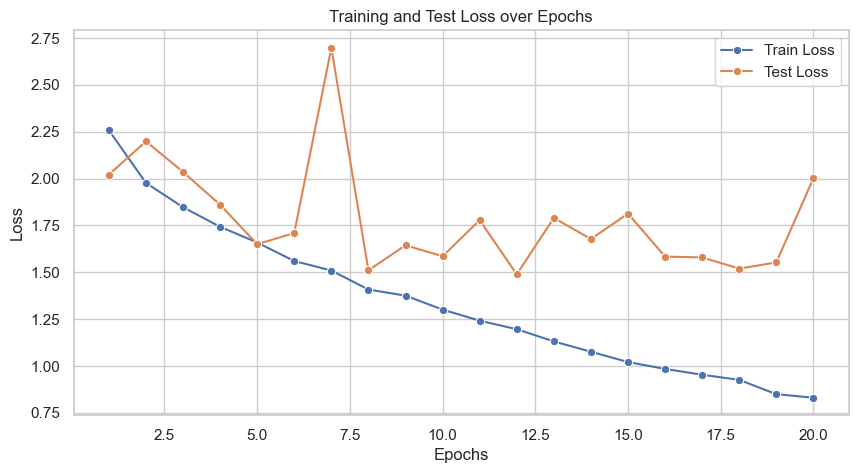

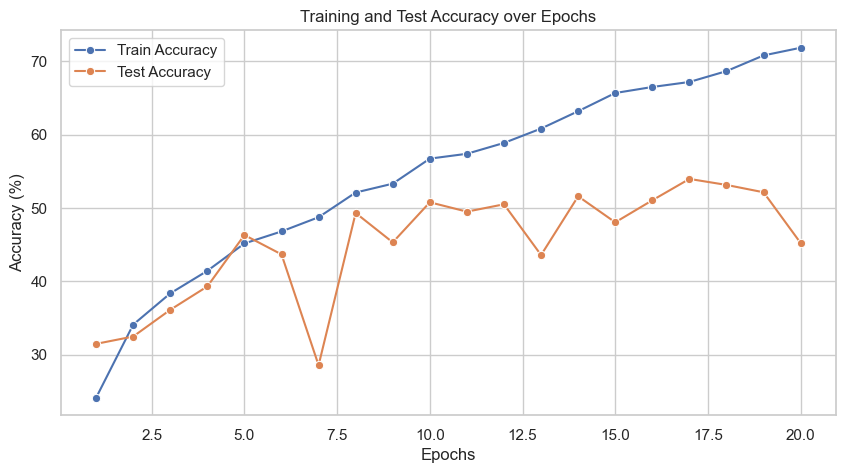

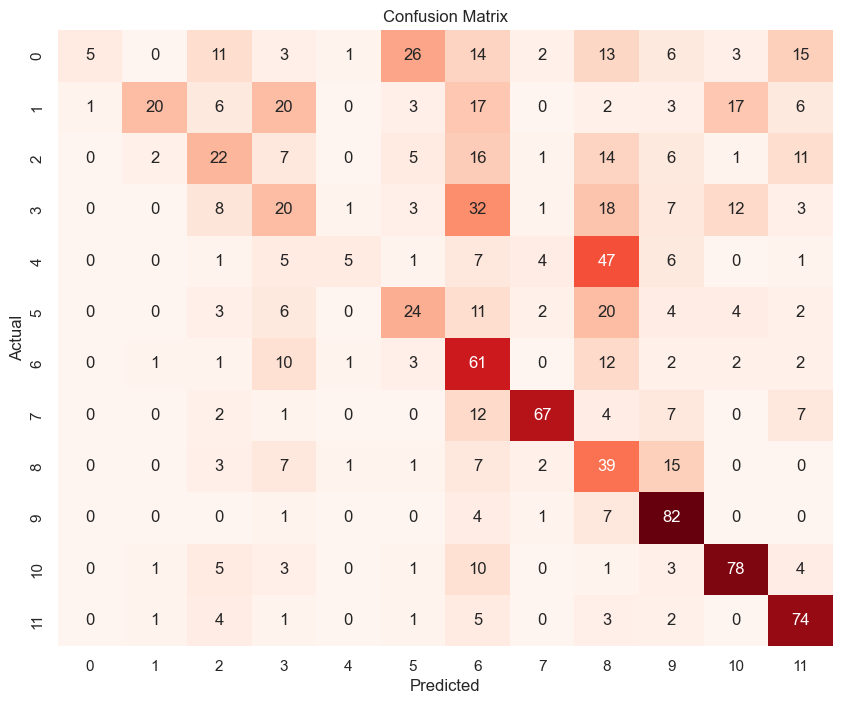

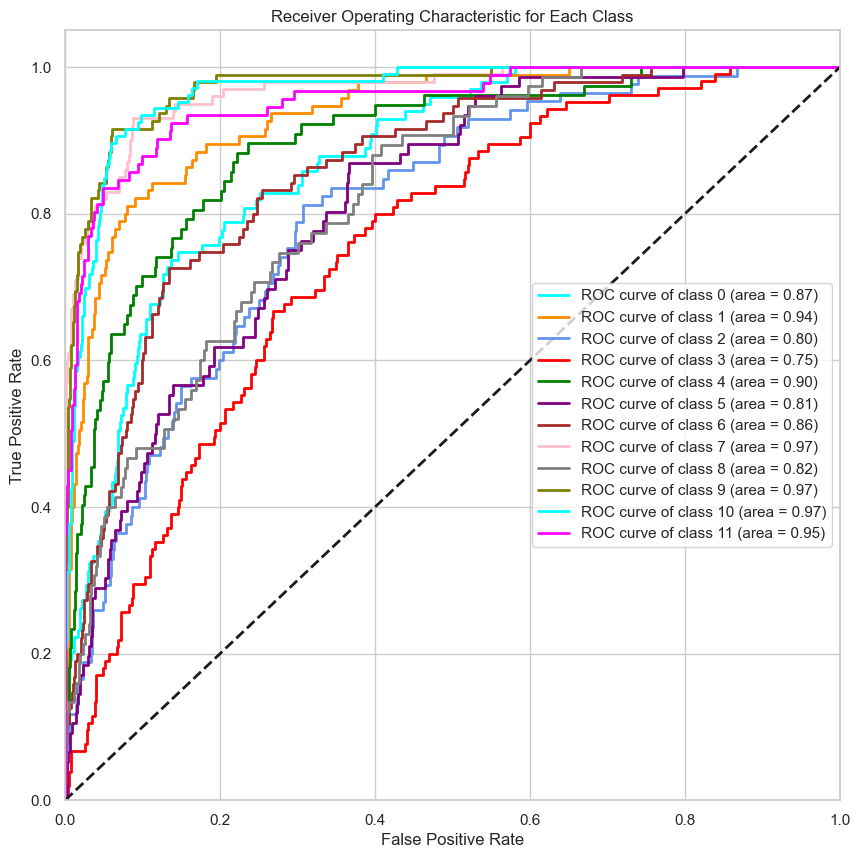

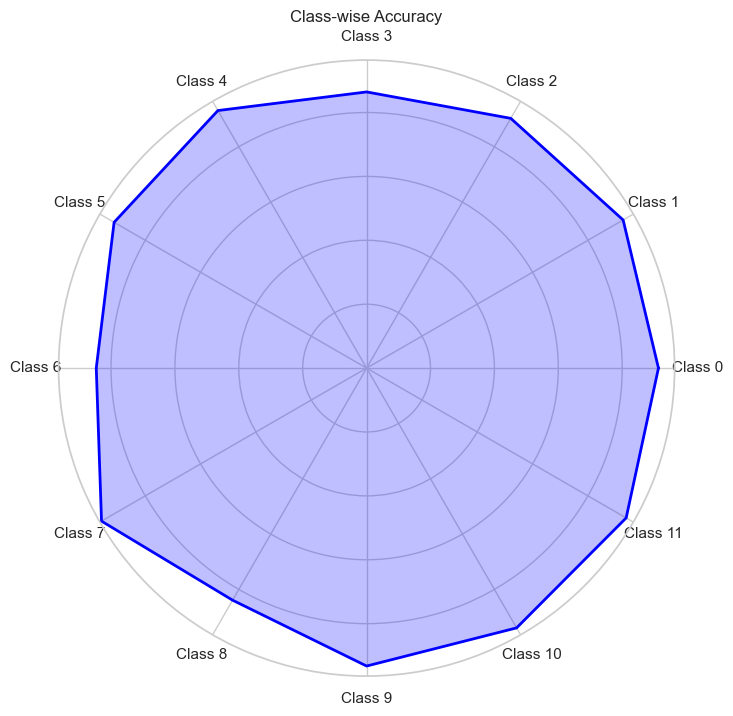

In [48]:
model2 = IntermediateCNN(num_classes=12)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=learn_rate)

torch.cuda.empty_cache()
train_model(model2,train_dataloader,test_dataloader,criterion, optimizer, num_epochs=num_epochs)
torch.cuda.empty_cache()

Epoch 1/20, Train Loss: 2.6344, Test Loss: 2.4279, Train Acc: 14.13%, Test Acc: 17.56%, Time: 118.64s
Epoch 2/20, Train Loss: 2.2323, Test Loss: 2.2995, Train Acc: 23.73%, Test Acc: 18.65%, Time: 120.76s
Epoch 3/20, Train Loss: 2.0904, Test Loss: 2.1727, Train Acc: 28.71%, Test Acc: 22.93%, Time: 113.59s
Epoch 4/20, Train Loss: 1.9181, Test Loss: 2.1272, Train Acc: 35.09%, Test Acc: 27.66%, Time: 116.65s
Epoch 5/20, Train Loss: 1.7550, Test Loss: 1.9489, Train Acc: 40.30%, Test Acc: 33.30%, Time: 94.09s
Epoch 6/20, Train Loss: 1.6500, Test Loss: 1.8649, Train Acc: 43.94%, Test Acc: 40.67%, Time: 102.79s
Epoch 7/20, Train Loss: 1.5130, Test Loss: 1.5789, Train Acc: 48.60%, Test Acc: 44.77%, Time: 109.46s
Epoch 8/20, Train Loss: 1.4298, Test Loss: 2.0593, Train Acc: 51.38%, Test Acc: 34.58%, Time: 111.41s
Epoch 9/20, Train Loss: 1.3263, Test Loss: 2.0147, Train Acc: 54.47%, Test Acc: 44.68%, Time: 110.33s
Epoch 10/20, Train Loss: 1.2325, Test Loss: 1.8618, Train Acc: 57.34%, Test Acc: 44

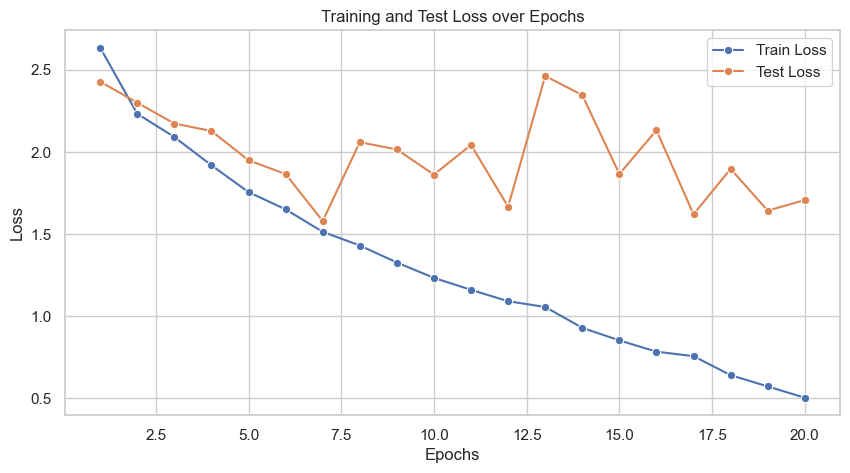

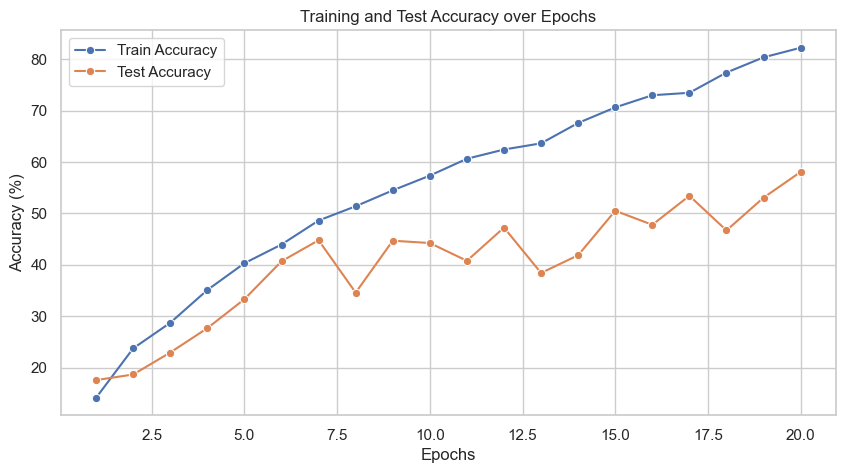

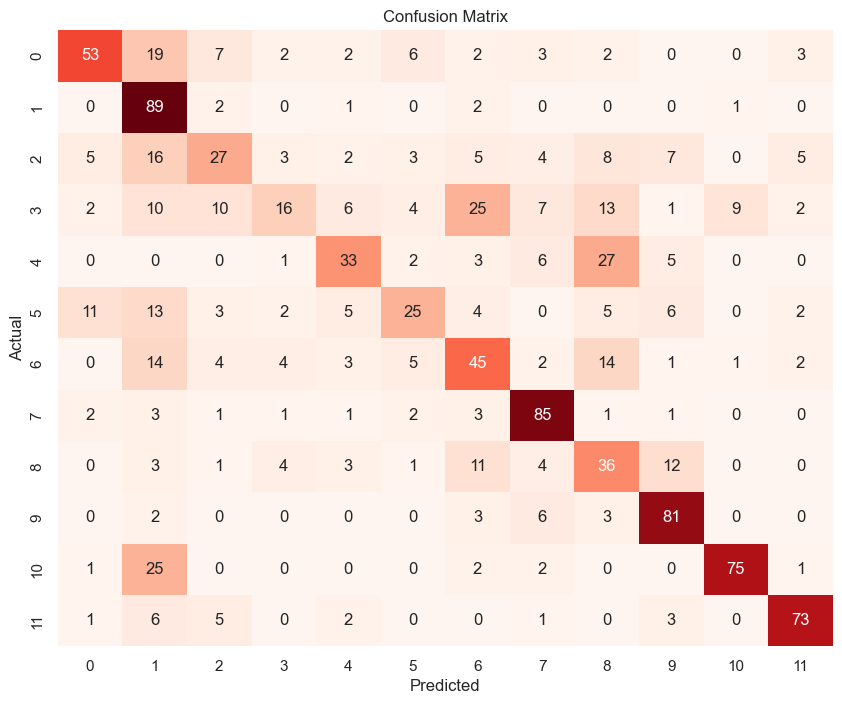

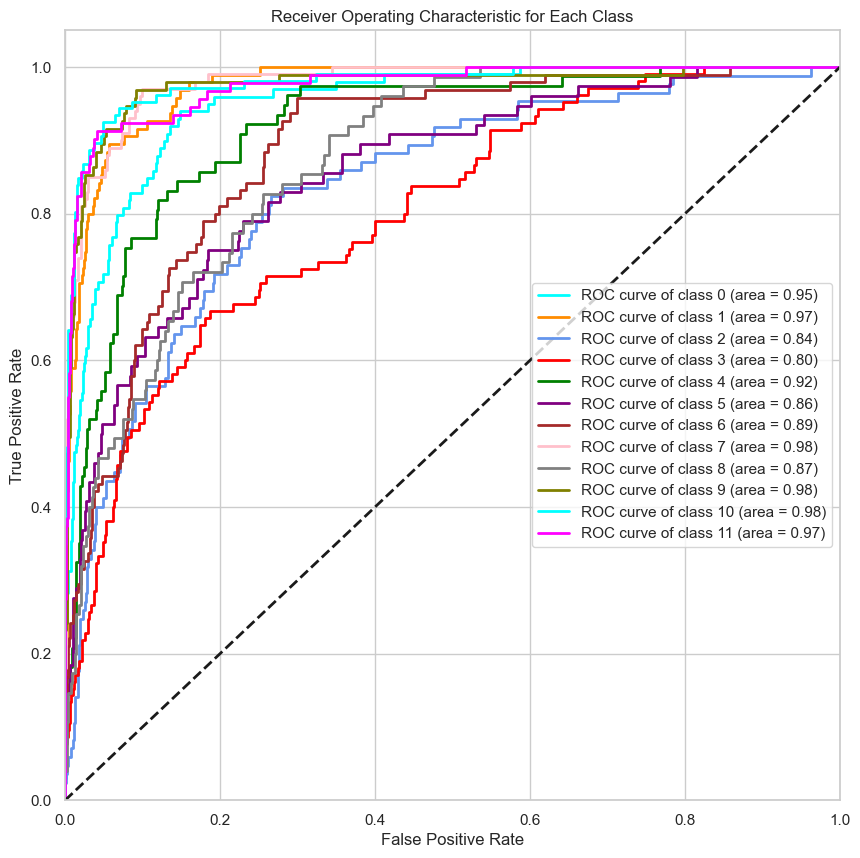

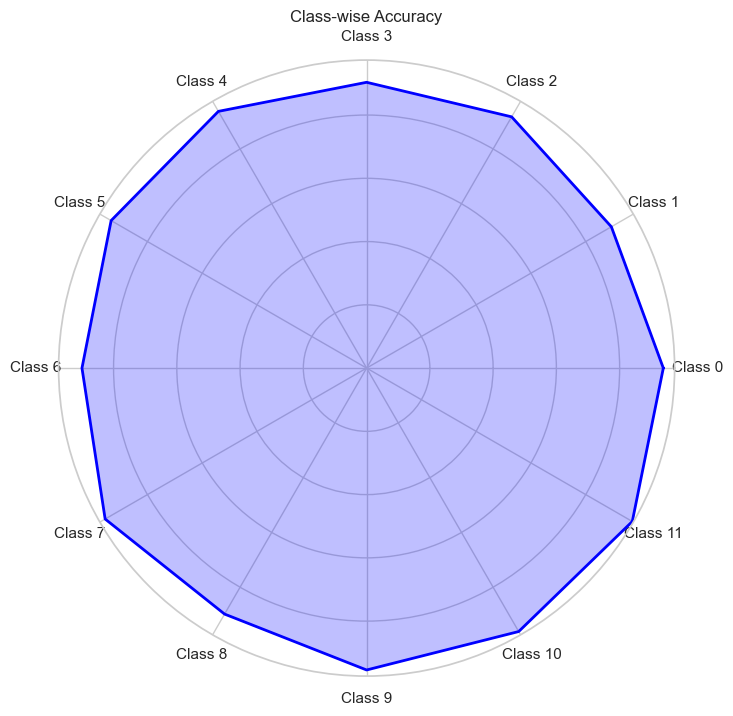

In [49]:
model3 = AdvancedCNN(num_classes=12)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=learn_rate)

torch.cuda.empty_cache()
train_model(model3,train_dataloader,test_dataloader,criterion, optimizer, num_epochs=num_epochs)
torch.cuda.empty_cache()